### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import time 

import matplotlib.pyplot as plt

# from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import kurtosis

from scipy.spatial.distance import cdist

from textwrap import wrap

### Load Dataset

In [3]:
RANDOM_SEED = 25


columns = ['Radius','Texture','Perimeter','Area','Smoothness','Compactness',
           'Concavity','Concave_Points','Symmetry','Fractal_Dimension',
           'Malignant/Benign']

# Read CSV file into pandas df
df = pd.read_csv('../datasets/breast_cancer/breast-cancer-wisconsin.csv',
                 delimiter=',', quotechar='"', names=columns)

### Dataframe without Preprocessing 

In [4]:
print("Printing dataframe head (without any preprocessing)....")
print(df.head(10))

Printing dataframe head (without any preprocessing)....
    Radius  Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
0  1000025        5          1     1           1            2         1   
1  1002945        5          4     4           5            7        10   
2  1015425        3          1     1           1            2         2   
3  1016277        6          8     8           1            3         4   
4  1017023        4          1     1           3            2         1   
5  1017122        8         10    10           8            7        10   
6  1018099        1          1     1           1            2        10   
7  1018561        2          1     2           1            2         1   
8  1033078        2          1     1           1            2         1   
9  1033078        4          2     1           1            2         1   

   Concave_Points  Symmetry  Fractal_Dimension  Malignant/Benign  
0               3         1                  1     

### Dataset Preprocessing 

In [5]:
# Shuffle
df = shuffle(df, random_state=RANDOM_SEED)

# DROP USELESS ROWS AND COLUMNS
df.dropna(inplace=True)
cols = [0]
# Drop ID column (it's not attribute or target)
df.drop(df.columns[cols],axis=1,inplace=True)
# Drop all data points with missing variables  (denoted by '?' entry)
nostrings_row_list = [x.isdigit() for x in df.iloc[:,5]]
df = df[nostrings_row_list]


# Handle categorical data
# df = pd.get_dummies(df)


# Split data into X and y vectors
X = df.ix[:, df.columns != 'Malignant/Benign']
y = df['Malignant/Benign']

# Change 2 -> 0 (benign) and 4 -> 1 (malignant)
y.replace(2, 0, inplace=True)
y.replace(4, 1, inplace=True)

/home/saksham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### Sanity Check on Dataframe 


In [6]:
print("Sanity Check: Printing out dataframe and shape after preprocessing... ")
print(df.head(10))
print("df.shape: ", df.shape)


Sanity Check: Printing out dataframe and shape after preprocessing... 
     Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
437        4          1     1           1            2         1   
511        5          1     1           1            2         1   
215        8          7     8           7            5         5   
684        1          1     1           1            2         1   
302       10         10    10           7            9        10   
341        1          1     1           1            2         1   
608        5         10    10          10           10        10   
366        6         10    10          10            8        10   
205        5         10    10           9            6        10   
270        8          4     7           1            3        10   

     Concave_Points  Symmetry  Fractal_Dimension  Malignant/Benign  
437               1         1                  1                 0  
511               2         1             

### Training and Testing Split, Scaling 

In [7]:
# # Split into 30%  training data, 70% testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.30, random_state=RANDOM_SEED)


# # Apply scaling. Large values of certain features undesireable for NN
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### Sanity Check on X

In [8]:
print(X)

     Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
437        4          1     1           1            2         1   
511        5          1     1           1            2         1   
215        8          7     8           7            5         5   
684        1          1     1           1            2         1   
302       10         10    10           7            9        10   
341        1          1     1           1            2         1   
608        5         10    10          10           10        10   
366        6         10    10          10            8        10   
205        5         10    10           9            6        10   
270        8          4     7           1            3        10   
586        8         10    10          10            6        10   
264        7          9     4          10           10         3   
554        3          1     1           1            2         1   
509        2          1     1           1       

### VT - (Followed by Clustering Later)

In [27]:
# Specify number of eignevectors to use for PCA 

thresh = 0

vt = VarianceThreshold(threshold=thresh)
X_dim_reduced = vt.fit(X).transform(X)
print(vt.variances_)


[ 7.94504479  9.38135733  8.91853827  8.19370232  4.93487306 13.25825475
  5.99222704  9.30512831  2.99776415]


### Change the threshold hyperparameter

In [25]:
# Specify number of eignevectors to use for PCA 

thresh = 0
thresh_list = [t for t in range(2, 11)]

error_list = []

for thresh in thresh_list: 
    print("Threshold variance: ", thresh)
    
    vt = VarianceThreshold(threshold=thresh)
    X_dim_reduced = vt.fit(X).transform(X)
    print("X_dim_reduced.shape: ", X_dim_reduced.shape)
    
    clf_dimReduced = KMeans(n_clusters=2, random_state=0)
    clf_dimReduced.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, clf_dimReduced.predict(X_dim_reduced))
    error_dimReduced = min(error_dimReduced, 1 - error_dimReduced)
    error_list.append(error_dimReduced)

    print("Printing error_dimReduced ... ", error_dimReduced)


Threshold variance:  2
X_dim_reduced.shape:  (683, 9)
Printing error_dimReduced ...  0.03953147877013177
Threshold variance:  3
X_dim_reduced.shape:  (683, 8)
Printing error_dimReduced ...  0.0380673499267935
Threshold variance:  4
X_dim_reduced.shape:  (683, 8)
Printing error_dimReduced ...  0.0380673499267935
Threshold variance:  5
X_dim_reduced.shape:  (683, 7)
Printing error_dimReduced ...  0.040995607613469986
Threshold variance:  6
X_dim_reduced.shape:  (683, 6)
Printing error_dimReduced ...  0.03953147877013177
Threshold variance:  7
X_dim_reduced.shape:  (683, 6)
Printing error_dimReduced ...  0.03953147877013177
Threshold variance:  8
X_dim_reduced.shape:  (683, 5)
Printing error_dimReduced ...  0.04245973645680823
Threshold variance:  9
X_dim_reduced.shape:  (683, 3)
Printing error_dimReduced ...  0.04685212298682284
Threshold variance:  10
X_dim_reduced.shape:  (683, 1)
Printing error_dimReduced ...  0.11273792093704246


### Plot the MSE with changing threshold

No handles with labels found to put in legend.


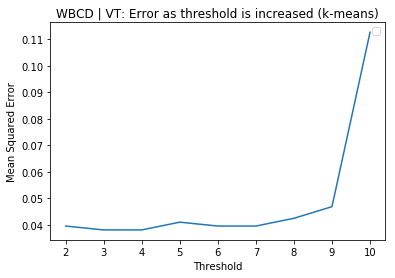

In [29]:
plt.plot(thresh_list, error_list, '-')
plt.title('WBCD | VT: Error as threshold is increased (k-means)')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('WBCD_VT_K-means.png')
plt.show()

### Change threshold and use EM 

In [30]:
# Specify number of eignevectors to use for PCA 

thresh = 0
thresh_list = [t for t in range(2, 11)]

error_list = []

for thresh in thresh_list: 
    print("Threshold variance: ", thresh)
    
    vt = VarianceThreshold(threshold=thresh)
    X_dim_reduced = vt.fit(X).transform(X)
    print("X_dim_reduced.shape: ", X_dim_reduced.shape)
    
    clf_dimReduced = GaussianMixture(n_components=2,covariance_type='full',n_init=10,max_iter=200)
    clf_dimReduced.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, clf_dimReduced.predict(X_dim_reduced))
    error_dimReduced = min(error_dimReduced, 1 - error_dimReduced)
    error_list.append(error_dimReduced)

    print("Printing error_dimReduced ... ", error_dimReduced)


Threshold variance:  2
X_dim_reduced.shape:  (683, 9)
Printing error_dimReduced ...  0.12298682284040996
Threshold variance:  3
X_dim_reduced.shape:  (683, 8)
Printing error_dimReduced ...  0.14641288433382138
Threshold variance:  4
X_dim_reduced.shape:  (683, 8)
Printing error_dimReduced ...  0.14641288433382138
Threshold variance:  5
X_dim_reduced.shape:  (683, 7)
Printing error_dimReduced ...  0.1595900439238653
Threshold variance:  6
X_dim_reduced.shape:  (683, 6)
Printing error_dimReduced ...  0.15666178623718888
Threshold variance:  7
X_dim_reduced.shape:  (683, 6)
Printing error_dimReduced ...  0.15666178623718888
Threshold variance:  8
X_dim_reduced.shape:  (683, 5)
Printing error_dimReduced ...  0.15666178623718888
Threshold variance:  9
X_dim_reduced.shape:  (683, 3)
Printing error_dimReduced ...  0.15373352855051248
Threshold variance:  10
X_dim_reduced.shape:  (683, 1)
Printing error_dimReduced ...  0.11859443631039532


### Plot MSE with changing threshold 

No handles with labels found to put in legend.


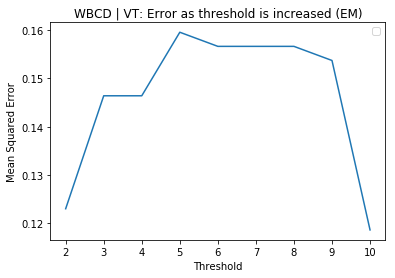

In [31]:
plt.plot(thresh_list, error_list, '-')
plt.title('WBCD | VT: Error as threshold is increased (EM)')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('WBCD_VT_EM.png')
plt.show()